#IMPORT

In [1]:
import pandas as pd
import numpy as np
import sklearn as skt
import seaborn as sns
import random as rand

#GENERATION OF DATA FOR EXAMPLE OF TREES

In [2]:
class_A=[(rand.uniform(20,30),rand.uniform(0,10))for i in range(20)]+[(rand.uniform(24,29),rand.uniform(2,8))for i in range(25)]
class_B=[(rand.uniform(0,10),rand.uniform(20,30))for i in range(20)]+[(rand.uniform(2,5),rand.uniform(24,27))for i in range(25)]
class_C=[(rand.uniform(8,23),rand.uniform(6,25))for i in range(20)]+[(rand.uniform(12,15),rand.uniform(12,18))for i in range(55)]
Classes=[class_A,class_B,class_C]

In [3]:
Table_A=pd.DataFrame({"X":[i[0] for i in class_A],"Y":[i[1] for i in class_A],"Class":['A'for i in class_A]})
Table_B=pd.DataFrame({"X":[i[0] for i in class_B],"Y":[i[1] for i in class_B],"Class":['B'for i in class_B]})
Table_C=pd.DataFrame({"X":[i[0] for i in class_C],"Y":[i[1] for i in class_C],"Class":['C'for i in class_C]})

Table_All= pd.concat([Table_A, Table_B,Table_C], axis=0)
Table_All

,X,Y,Class
0,21.085308,6.274651,A
1,26.739999,6.252628,A
2,22.466696,2.954812,A
3,20.405150,4.850174,A
4,27.731590,1.300795,A
...,...,...,...
70,12.441413,14.073340,C
71,12.888421,12.218142,C
72,14.653421,16.629996,C
73,13.770504,15.737731,C


1.тут нужно посчитать вероятности для каждого класса.
2.Нужно написать функцию Branch()
3.Максимизация бранча, минимизация лосса(для одного пня )

$p_k=\frac{|x_i\in Class_k|}{|X_m|}$


$H(X_m) = \sum_{k = 1}^K p_{k,m} (1 - p_{k,m})$


$H(X_m) = -\sum_{k = 1}^K p_{k,m} \log p_{k,m}$


$Branch (X_m, j, t) = |X_m| \cdot H(X_m) -  |X_l| \cdot H(X_l) -  |X_r| \cdot H(X_r)$


Критерий остановки $Stop(X_m,C)=[len(X_m)<=C]$
или количество уровней.


#CREATING OF DECISION TREE

In [4]:
def H_Gini(X_m):
  s=0
  for k in ["A","B","C"]:
    p_k=len(X_m[X_m.Class==k])/len(X_m)
    s+=p_k*(1-p_k)
  return s
def H(X_m):
  s=0
  if len(X_m)!=0:
   for k in ["A","B","C"]:
     p_k=len(X_m[X_m.Class==k])/len(X_m)
     if(p_k!=0):
        s+=p_k*np.log(p_k)
  return -s
def Branch(X_m,j,t):
  return len(X_m)*H(X_m)-len(X_m[X_m.iloc[:,j]<=t])*H(X_m[X_m.iloc[:,j]<=t]) -len(X_m[X_m.iloc[:,j]>t])*H(X_m[X_m.iloc[:,j]>t])

def max_class(Tab):
  m=-1000000
  k="No_Class"
  for i in Tab.groupby("Class").Class.count().index:
    if m<=Tab.groupby("Class").Class.count()[i]:
       k=i
       m=Tab.groupby("Class").Class.count()[i]

  return k


class Tree():
 def __init__(self,cond,left,right):
  self.cond=cond
  self.left=left
  self.right=right




class Classific_Tree():# Можно было бы отнаследоваться или чито на основе прошлого сделать
  def __init__(self,Branch,condition_tree=0):
      self.condition_tree=condition_tree #Дерево условий, в листах которого классы-предикты
      self.Branch=Branch # Максимизируем функцию ветвления на предикатах, чтобы в следующих деревьях уменьшить лосс-H(например энтропию)
      self.jt0=[]
  def maximization(self,X_m): #Максимизация на X_m  Branch'a - выбираем оптимальную пару J_opt, t_opt - фича и порог в ней.Ну иуи классичекий алгоритм поиска макс.+критерий выбора Branch
    maxi=-1000
    j_opt,t_opt=0,0
    for j in range(len(X_m.columns)-1):
      jj=max([X_m[kk].max() for kk in X_m.columns[:2]])
      for t in range(int(jj)):
          k=self.Branch(X_m,j,t)
          if maxi<k:
             maxi=k
             j_opt,t_opt=j,t
    X_l,X_r=X_m[X_m.iloc[:,j_opt]<=t_opt],X_m[X_m.iloc[:,j_opt]>t_opt]
    return (X_l,X_r,j_opt,t_opt)
  def creation_X_Tree(self,X_m,Stop_C,jt_opt=[]):    #Создаем X_tree c помощью рекурсии.
    if X_m.empty==True: return "No_Class" #Если вдруг изрезали датафрейм так, что не осталось ничего
    elif Stop_C==1:# Если добрались до корней
       return max_class(X_m)
    else: # Добираемся до "листов" дерева.А потом возвращаемся обратно с цепочкой "стволов"
       X_l,X_r,j,t= self.maximization(X_m)
       return Tree((j,t),self.creation_X_Tree(X_l,Stop_C-1,(j,t)),self.creation_X_Tree(X_r,Stop_C-1,(j,t)))

  def creation_Tree(self,X_m,Stop_C=2,jt_opt=[]):    #Создаем condition_tree c помощью рекурсии.
       self.condition_tree=self.creation_X_Tree(X_m,Stop_C,jt_opt=[])
  def forward(self,X):
      Tr=self.condition_tree
      while type(Tr)!=str:
        if X[Tr.cond[0]]<=Tr.cond[1]:
            Tr=Tr.left
        else:
            Tr=Tr.right
      return Tr




#PREDICT

Распределение по классам взятых наудачу(по каждой из осей отдельно) точек из квадрата $[0,30]\times[0,30]$
Всего взято 100 точек

In [5]:
Predicter=Classific_Tree(Branch)
Predicter.creation_Tree(Table_All,6)

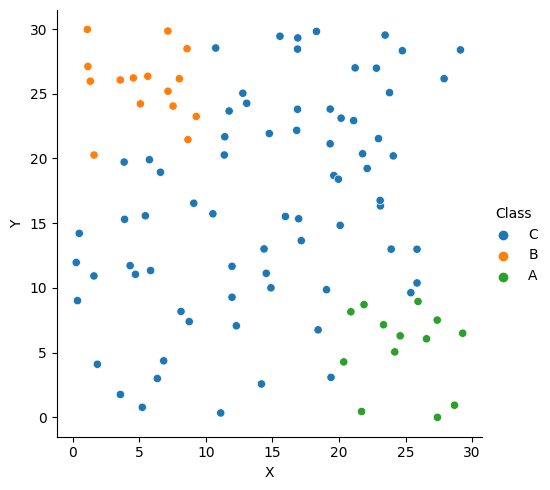

In [7]:
proto_table={"X":[],"Y":[],"Class":[]}
for i in range(100):
  a=rand.uniform(0, 30)
  b=rand.uniform(0, 30)
  proto_table["X"].append(a)
  proto_table["Y"].append(b)
  proto_table["Class"].append(Predicter.forward((a,b)))

New_Table=pd.DataFrame(proto_table)
sns.relplot(data=New_Table, x="X", y="Y", hue="Class")

Оригинальное распределение классов

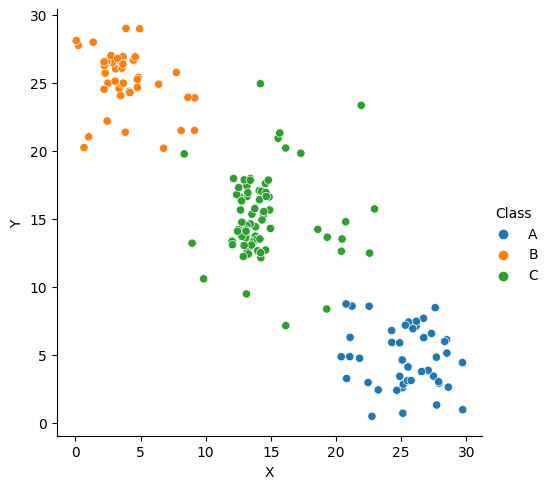

In [8]:
sns.relplot(data=Table_All, x="X", y="Y", hue="Class")